In [1]:
import pymc4 as pm
import numpy as np
import arviz as az

# The Eight Schools Model

The hierarchical model of the Eight Schools dataset (Rubin 1981) as seen in Stan:


\begin{align}
\mu \sim& \mathcal{N}(0, 5) \\
\tau \sim& \text{Half-Cauchy}(0, 5) \\
\theta_{n} \sim& \mathcal{N}(\mu, \tau) \\
y_{n} \sim& \mathcal{N}(\theta_{n}, \sigma_{n})
\end{align}


where $n \in \{1, \cdots, 8\}$ and the $\{y_n,\sigma_n\}$ are given as data.

In [3]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12], dtype=np.float32)
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18], dtype=np.float32)

In [4]:
@pm.model
def schools_pm4():
    eta = yield pm.Normal("eta", 0, 1, plate=J)
    mu = yield pm.Normal("mu", 0, 1, plate=1)
    tau = yield pm.HalfNormal('tau', 2., plate=1)
    
    theta = mu + tau * eta

    obs = yield pm.Normal('obs', theta, scale=sigma, observed=y)

    return obs

tf_trace, sample_stats  = pm.sample(schools_pm4())

In [7]:
az_trace = pm.trace_to_arviz(tf_trace, sample_stats)

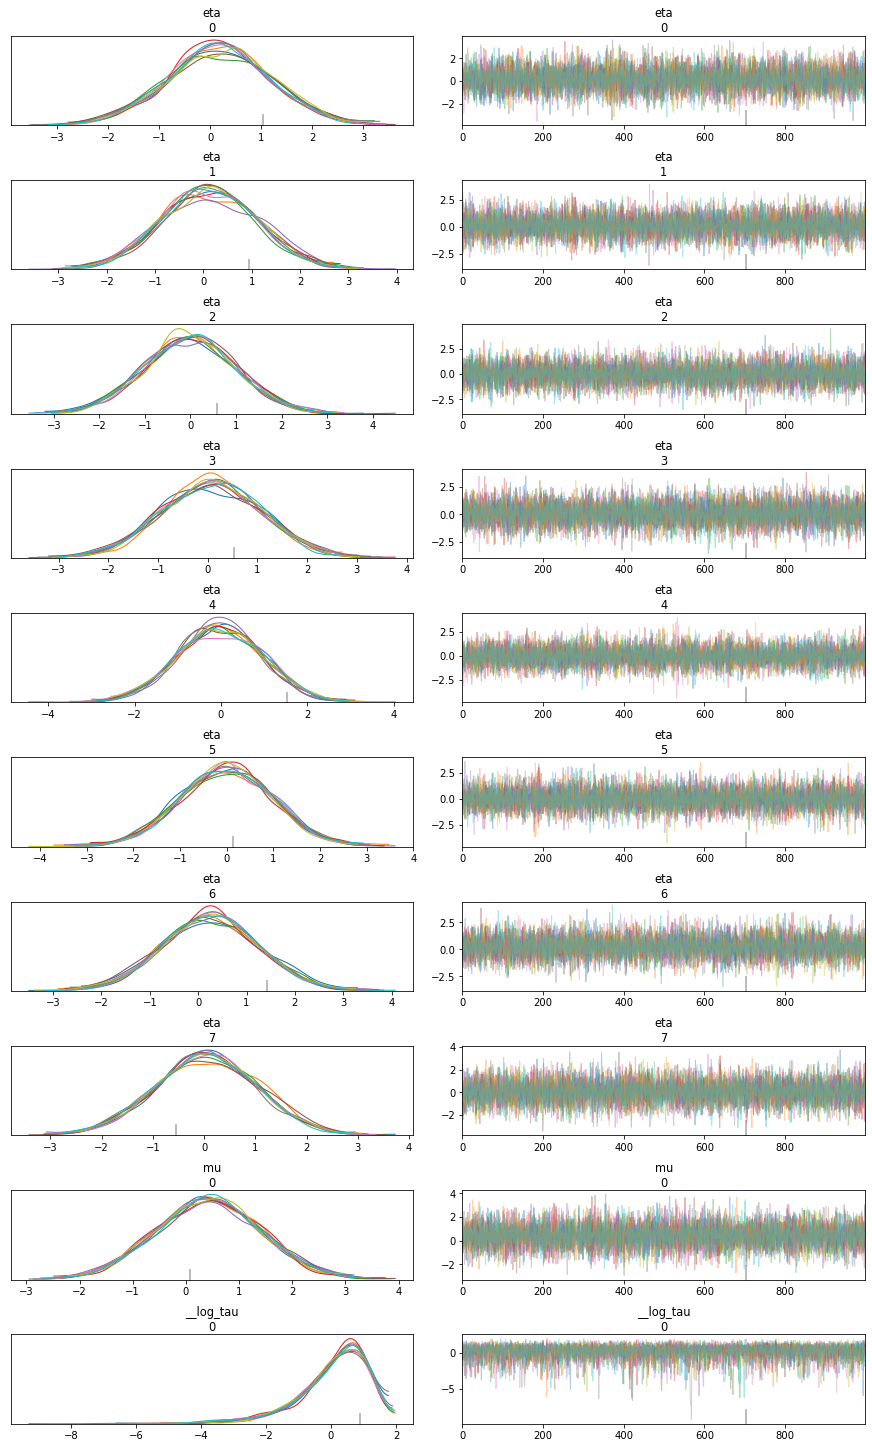

In [10]:
az.plot_trace(az_trace);